# Praktikum 6 DL2021
## Jaringan Neural Dalam
> Muhammad Naufal Irham Ramdhani (10818019)




# TUGAS

1. Lengkapi kode di atas dan tuliskan menjadi OOP
2. Cari dataset gambar lain yang berupa klasifikasi sederhana dengan >2 kategori. Latih modelnya hingga paling tidak mendapatkan akurasi 80 persen

### 1. Persiapan


#### 1.1. Import library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from PIL import Image
import random
import os

# mengatur ukuran universal gambar apapun yang diplot 
plt.rcParams['figure.figsize'] = (10.0, 10.0) 
%matplotlib inline

# Jawaban no. 2

Dataset diambil dari:
---
https://www.kaggle.com/chetankv/dogs-cats-images

#### 1.2. Memuat data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [4]:
#changing the working directory
%cd /content/drive/My Drive/Kaggle
#Check the present working directory using pwd command

/content/drive/My Drive/Kaggle


In [5]:
!kaggle datasets download -d chetankv/dogs-cats-images

 97% 422M/435M [00:03<00:00, 131MB/s]
100% 435M/435M [00:03<00:00, 133MB/s]


Berkas yang diunduh berupa file zip, sehingga perlu kita ekstrak terlebih dahulu

In [6]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: dog vs cat/dataset/training_set/cats/cat.37.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.370.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3700.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3701.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3702.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3703.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3704.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3705.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3706.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3707.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3708.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3709.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.371.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3710.jpg  
  inflating: dog vs cat/dataset/training_se

#### 1.3. Mempersiapkan dataset

##### 1.3.1 Memuat data gambar

In [7]:
categories = ["cats", "dogs"] # isi dengan nama folder kategori yang berisi data 
def obtain_images_data(base_dir):
    images = []
    for i, category in enumerate(categories):
        directory = base_dir + category
        for item in os.listdir(directory):
            fname = directory + "/" + item
            image = Image.open(fname)
            image = image.resize((64,64),Image.ANTIALIAS)
            image_array = np.array(image)[:,:]
            images.append((image_array, i))

    # diacak dulu biar tidak bias
    random.shuffle(images) # gunakan salah satu metode dari "random" 
    return images

labeled_images = obtain_images_data('/content/drive/MyDrive/Kaggle/dog vs cat/dataset/training_set/')

(64, 64, 3)
Ini adalah gambar 'dogs'


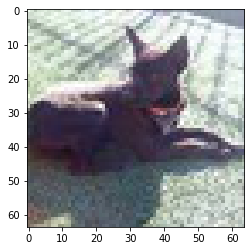

In [8]:
# periksa salah satu gambar
sample_image = labeled_images[0]
print(sample_image[0].shape)
plt.imshow(sample_image[0])
print(f"Ini adalah gambar '{categories[sample_image[1]]}'")

##### 1.3.2 Membagi data gambar

Kita pisahkan data gambar dengan labelnya menjadi dua variabel yang berbeda

In [9]:
def split(images_list):
    images, labels = zip(*labeled_images)
    # ubah images dan labels masing-masing menjadi array dan namakan X dan Y
    X = np.array(images)
    Y = np.array(labels)
    return X, Y  

train_set_x_orig, train_set_y = split(labeled_images)

In [10]:
m_train = len(train_set_x_orig)
num_px = train_set_x_orig[0].shape[0]

print ("Number of training examples: m_train = " + str(m_train))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 4)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))

Number of training examples: m_train = 8000
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 4)
train_set_x shape: (8000, 64, 64, 3)
train_set_y shape: (8000,)


##### 1.3.3. Preprocess data gambar

Selanjutnya, untuk memudahkan, kita akan peringkas bentuk inputnya agar cukup memilliki 2  dimensi. Istilahnya, kita datarkan (*flatten*) datanya sehingga seakan seperti data numerik biasa. 

In [11]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T 
print(train_set_x_flatten[-1])
train_y = np.expand_dims(train_set_y, 0)

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_y.shape))

[178  97  16 ...   1 135 126]
train_set_x_flatten shape: (12288, 8000)
train_set_y shape: (1, 8000)


In [12]:
# normalize
train_x = train_set_x_flatten/255

##### 1.3.4 Menyiapkan data testing

Kita ingin memakai sebagian data gambarnya untuk testing, agar kita bisa tahu apakah model kita *overfit* atau bisa *generalize*. Kita lakukan semua hal yang sama di atas untuk mendapatkan test data

In [13]:
test_set_x_orig, test_set_y = split(obtain_images_data('/content/drive/MyDrive/Kaggle/dog vs cat/dataset/test_set/'))
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
test_y = np.expand_dims(test_set_y, 0)
# normalize
test_x = train_set_x_flatten/255

### 2. Membangun Model (DNN)

Yang kita lakukan setelah ini serupa dengan apa yang dilakukan pada praktikum sebelumnya. Bedanya, layer tersembunyi yang digunakan bisa lebih dari satu, yang kita generalisasi menjadi $L$.

# Jawaban no.1

#### Fungsi Aktivasi yang Digunakan

In [14]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def relu_backward(dA, Z):
    dZ         = np.array(dA, copy = True)
    dZ[Z <= 0] = 0
    return dZ

def sigmoid_backward(dA, Z):
    s  = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

#### Deep learning dengan OOP

In [15]:
class DNN(object):
    def __init__(self, X, Y, layer_dims, learning_rate = 0.0075):
        self.X = X
        self.Y = Y
        self.learning_rate = learning_rate
        self.parameters = {}
        L = len(layer_dims)       
        for l in range(1, L):
            # pastikan dimensinya tepat
            self.parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])/np.sqrt(layer_dims[l-1])
            self.parameters['b' + str(l)] = np.zeros((layer_dims[l],1))

    def forward_layer(self, A_prev, W, b, activation): #perhitungan forward
        Z = np.dot(W, A_prev) + b
        if activation == "sigmoid":
            A = sigmoid(Z)
        elif activation == "relu":
            A = relu(Z)
        return A, Z

    def forward_propagation(self, X):
        self.Zl, self.Al = [], [X]
        L  = len(self.parameters) // 2 # jumlah total layer (selain input)
        
        for l in range(1, L+1):
            A_prev = self.Al[l-1]
            wl = self.parameters['W' + str(l)]
            bl = self.parameters['b' + str(l)]
            if l < L:
                activation = 'relu'
            else:
                activation = 'sigmoid' 
            A, Z = self.forward_layer(A_prev, wl, bl, activation)
            self.Zl.append(Z)
            self.Al.append(A)
            
    def backward_layer(self, dA, Z, A_prev, w, activation):    
        if activation == "relu":
            dZ = relu_backward(dA, Z)        
        elif activation == "sigmoid":
            dZ = sigmoid_backward(dA, Z)

        m  = A_prev.shape[1]    
        dW = np.dot(dZ, A_prev.T)/m
        db = np.sum(dZ, axis = 1, keepdims = True)/m
        dA_prev = np.dot(w.T, dZ)

        return dA_prev, dW, db

    def backward_propagation(self):
        L = len(self.Zl) 
        grads = {}
        A = self.Al[-1]
        m = A.shape[1]
        Y = self.Y.reshape(A.shape)
        # turunan dari binary crossentropy. Hint: gunakan np.divide 
        dA_prev = - (np.divide(Y,A) - np.divide(1-Y, 1-A))

        for l in reversed(range(L)):
            wl = self.parameters['W' + str(l+1)]
            if l == L-1:
                activation = "sigmoid"
            else:
                activation = "relu"
            dA_prev, dW, db = self.backward_layer(dA_prev, self.Zl[l], self.Al[l], wl, activation)
            grads["dA" + str(l)] = dA_prev
            grads["dW" + str(l + 1)] = dW
            grads["db" + str(l + 1)] = db
        
        self.grads = grads

    def update_parameters(self):    
        L = len(self.parameters) // 2 
        for l in range(L):
            self.parameters["W" + str(l+1)] -= self.learning_rate * self.grads["dW" + str(l+1)]
            self.parameters["b" + str(l+1)] -= self.learning_rate * self.grads["db" + str(l+1)]

    def predict(self, X, y, parameters):
        m = X.shape[1]
        p = np.zeros((1,m))
        self.forward_propagation(X)
        probas = self.Al[-1]

        for i in range(0, probas.shape[1]):
            if probas[0,i] > 0.5:
                p[0,i] = 1
            else:
                p[0,i] = 0
        
        print ("predictions: " + str(p))
        print ("true labels: " + str(y))
        print("Accuracy: "  + str(100*np.sum((p == y)/m)))
            
        return p

    def compute_cost(self, AL, Y):
        m = Y.shape[1]
        # binary crossentropy, gunakan np.multiply
        cost = -np.sum(np.multiply(np.log(AL), Y)+ np.multiply(np.log(1-AL), (1-Y)))/m
        cost = np.squeeze(cost) # Mengubah cost dalam array menjadi bilangan, misal [[17.]] menjadi 17.    
        return cost

### 3. Eksekusi

Sekarang, semua sudah siap, kita bangun modelnya!

In [16]:
hidden_neurons = [20, 7, 5] # tentukan banyaknya layers dan banyaknya neuron di setiap hidden layer
layers_dims = [train_x.shape[0]] + hidden_neurons + [1] 
alpha = 0.0075
Model = DNN(train_x, train_y, layers_dims, alpha)

Cost setelah iterasi ke-0: 0.699442
Cost setelah iterasi ke-10: 0.690223
Cost setelah iterasi ke-20: 0.688504
Cost setelah iterasi ke-30: 0.686874
Cost setelah iterasi ke-40: 0.685504


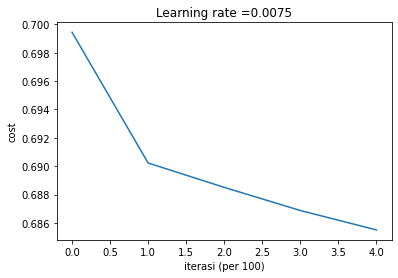

In [17]:
num_iterations = 50 #karena datanya ada 8000, agar ngerunnya ngga kelamaan, iterasinya sedikit saja
print_cost = True


costs = []

for i in range(0, num_iterations):
    Model.forward_propagation(Model.X) # forward prop
    cost       = Model.compute_cost(Model.Al[-1], Model.Y) # cost
    
    Model.backward_propagation() # backward prop

    Model.update_parameters() # update

    if print_cost and i % 10 == 0:
        print ("Cost setelah iterasi ke-%i: %f" %(i, cost))
        costs.append(cost)
        
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterasi (per 100)')
plt.title("Learning rate =" + str(alpha))
plt.show()

Performa cost-nya bagus? Mantap. Coba kita lihat hasil prediksi modelnya bagaimana

In [18]:
print("Prediksi pada data training:")
predictions_train = Model.predict(train_x, train_y, Model.parameters)
print("\nPrediksi pada data testing:")
predictions_test = Model.predict(test_x, test_y, Model.parameters)

#print("\nCek kalau ada gambar yang keliru:")
#print_mislabeled_images(categories, test_x, test_y, predictions_test)

Prediksi pada data training:
predictions: [[0. 1. 0. ... 1. 1. 0.]]
true labels: [[1 0 1 ... 1 1 1]]
Accuracy: 55.425000000000004

Prediksi pada data testing:
predictions: [[0. 1. 0. ... 1. 1. 0.]]
true labels: [[1 0 1 ... 1 1 1]]
Accuracy: 55.425000000000004


### Catatan
Seharusnya tingkat akurasi yang dihasilkan bisa lebih dari 80%, namun karena size datanya terlalu besar (8000 data), maka untuk melakukan iterasi yang banyak akan memakan sangat banyak waktu.

## Tes dengan gambar sendiri ##

Sekarang coba tes dengan gambar yang diupload sendiri. Buka menu `files` di sebelah kiri jendela. Upload gambar yang diinginkan di situ dan sesuaikan namanya di kode di bawah ini 

predictions: [[1.]]
true labels: 0.0
Accuracy: 0.0
y = 1.0, modelmu memprediksi ini sebagai gambar dogs


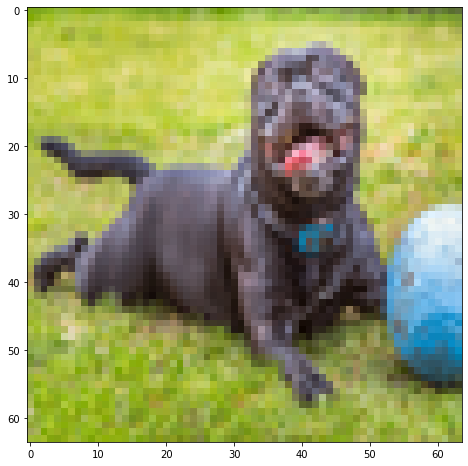

In [19]:
# silakan masukkan link gambar yang kamu ingin test di sini (dalam string!)
link = "https://img.webmd.com/dtmcms/live/webmd/consumer_assets/site_images/article_thumbnails/other/dog_cool_summer_slideshow/1800x1200_dog_cool_summer_other.jpg"
!wget -q -O ./test_image.jpg $link
# atau upload sendiri ke bagian file dan namakan ia jadi "test_image.jpg"
true_label = 0. # pilih 0 jika seharusnya itu gambar kuda, atau 1 kalau gambar orang

image = Image.open("./test_image.jpg")
image = image.resize((num_px,num_px),Image.ANTIALIAS)
image = np.array(image)
plt.figure(figsize=(8,8))
plt.imshow(image)
image = image.reshape((1, num_px*num_px*3)).T
my_image = image/255.
my_predicted_image = Model.predict(my_image, true_label, Model.parameters)
print("y = " + str(np.squeeze(my_predicted_image)) + ", modelmu memprediksi ini sebagai gambar " + categories[int(np.squeeze(my_predicted_image))])